# 13-3 Agent Orchestration을 위한 슈퍼바이저

In [1]:
# MessagesState를 상속받아 에이전트의 상태를 관리하는 클래스
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    # 다음 에이전트를 지정하는 변수
    next: str

In [2]:
# 필요한 타입과 라이브러리 임포트
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

# OpenAI 모델 설정
llm = ChatOpenAI(model='gpt-4o')

# 세금 계산을 위한 에이전트 목록 정의
members = ["house_tax_agent", "income_tax_agent"]
# 팀 수퍼바이저는 다음 에이전트를 선택하고 답변이 생성됐다고 판단하면 작업 완료를 결정
options = members + ["FINISH"]

# 다음 작업자를 지정하는 타입 정의
class Router(TypedDict):
    """다음 작업자를 결정하는 라우터.
    작업이 필요한 경우 다음 작업자를 지정하고,
    더 이상 작업이 필요하지 않은 경우 FINISH를 반환.
    """
    next: Literal[*options]


In [ ]:
from langgraph.graph import END
from langgraph.types import Command

# 수퍼바이저의 시스템 프롬프트 설정
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

def supervisor_node(state: AgentState) -> Command[Literal[*members, "__end__"]]:
    """수퍼바이저 노드 함수
    
    현재 상태를 기반으로 다음 작업자를 결정하고 명령을 반환합니다.
    
    Args:
        state: 현재 상태 객체
        
    Returns:
        Command: 다음 작업자로의 전환 명령과 상태 업데이트
    """
        # 시스템 프롬프트와 현재 상태의 메시지를 결합
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    
    # LLM을 사용하여 구조화된 출력(Router)으로 다음 작업자 결정
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    # 작업이 완료되면 END로 이동하여 사용자에게 답변 반환 
    if goto == "FINISH":
        goto = END

    # Command 객체 반환
    # Command는 그래프의 상태 전이를 제어하는 객체로:
    # - goto: 다음으로 실행할 노드를 지정
    # - update: 현재 상태를 업데이트할 데이터를 지정
    return Command(goto=goto, update={"next": goto})

In [ ]:
# 세금 계산 에이전트 모듈들을 임포트
from house_tax_agent import graph as house_tax_agent
from income_tax_agent import income_tax_agent
from langchain_core.messages import HumanMessage

def house_tax_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """종합부동산세 계산 노드 함수
    
    종합부동산세 에이전트를 실행하고 결과를 메시지 형태로 변환하여 반환합니다.
    실행이 완료되면 수퍼바이저 노드로 제어를 반환합니다.
    
    Args:
        state (AgentState): 현재 에이전트의 상태 정보
        
    Returns:
        Command: 수퍼바이저로의 전환 명령과 종합부동산세 계산 결과 메시지
    """
    # 종합부동산세 에이전트 실행
    result = house_tax_agent.invoke(state)
    
    # Command 객체 반환:
    # - update: 마지막 메시지를 HumanMessage 형태로 변환하여 상태 업데이트
    # - goto: 다시 수퍼바이저 노드로 제어 반환
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="house_tax_agent")
            ]
        },
        goto="supervisor",
    )


def income_tax_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """소득세 계산 노드 함수
    
    소득세 에이전트를 실행하고 결과를 메시지 형태로 변환하여 반환합니다.
    실행이 완료되면 수퍼바이저 노드로 제어를 반환합니다.
    
    Args:
        state (AgentState): 현재 에이전트의 상태 정보
        
    Returns:
        Command: 수퍼바이저로의 전환 명령과 소득세 계산 결과 메시지
    """
    # 소득세 에이전트 실행
    result = income_tax_agent.invoke(state)
    
    # Command 객체 반환:
    # - update: 마지막 메시지를 HumanMessage 형태로 변환하여 상태 업데이트
    # - goto: 다시 수퍼바이저 노드로 제어 반환
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="income_tax_agent")
            ]
        },
        goto="supervisor",
    )

/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 상태 그래프와 시작 노드를 위한 클래스 임포트
from langgraph.graph import StateGraph, START

# AgentState 클래스를 사용하여 상태 그래프 빌더 생성
builder = StateGraph(AgentState)

# 시작 노드(START)를 수퍼바이저 노드와 연결
# 모든 실행은 수퍼바이저 노드에서 시작된다.
builder.add_edge(START, "supervisor")

# 각 노드들을 그래프에 추가
# - supervisor_node: 작업 흐름을 제어하는 수퍼바이저 노드
# - house_tax_node: 주택세 계산을 담당하는 노드
# - income_tax_node: 소득세 계산을 담당하는 노드
builder.add_node("supervisor", supervisor_node)
builder.add_node("house_tax_agent", house_tax_node)
builder.add_node("income_tax_agent", income_tax_node)

# 그래프를 컴파일하여 실행 가능한 상태로 만듦
# 컴파일된 그래프는 노드들 간의 상태 전이와 메시지 전달을 처리
graph = builder.compile()

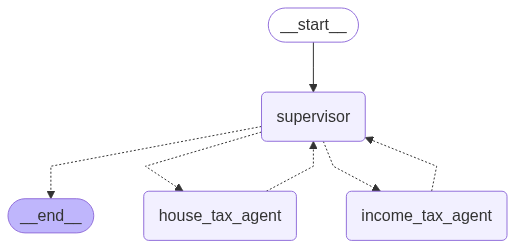

In [6]:
graph

In [9]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage("연봉 5천만 원의 소득세는 얼마인가요?")]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

연봉 5천만 원의 소득세는 얼마인가요?
================================== Ai Message ==================================
Name: income_tax_agent

2025년 대한민국의 소득세 과세표준에 따르면, 연봉 5천만 원에 대한 소득세는 다음과 같이 계산됩니다:

1. 과세표준 1,400만원까지는 6%의 세율이 적용됩니다.
2. 나머지 3,600만원(5,000만원 - 1,400만원)에 대해서는 15%의 세율이 적용됩니다.

따라서 계산은 다음과 같습니다:

- 1,400만원에 대한 세금: 1,400만원 x 6% = 84만원
- 1,400만원 초과분에 대한 세금: (5,000만원 - 1,400만원) x 15% = 540만원

이 두 금액을 합산하면, 총 소득세는 624만원이 됩니다.

따라서, 연봉 5천만 원에 대한 소득세는 **624만원**입니다.

In [10]:
for chunk in graph.stream({'messages': [HumanMessage("집이 13억일 때 세금은 얼마인가요?")]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 13억일 때 세금은 얼마인가요?
================================== Ai Message ==================================
Name: house_tax_agent

현재 귀하의 질문은 주택에 대한 세금 계산에 관한 것으로 보입니다. 이에 따라 주택 가치가 13억 원일 경우의 세금을 간단히 계산해보겠습니다.

한국의 주택 세금 제도는 여러 요소를 고려하여 산정되지만, 여기에 가장 기본적인 주택 보유세(종합부동산세)를 기반으로 한 예시를 제시하겠습니다. 정확한 계산을 위해서는 보다 상세한 정보(학보율, 공정시장가액비율, 공제항목 등)가 필요하다는 점을 유념하시기 바랍니다.

1. **공시가격**: 주택의 공정가액비율을 고려하여 공시가격을 산정해야 합니다.
2. **과세표준** 계산: 공시가격에서 공제액을 뺀 후, 과세표준율을 곱해 과세표준을 계산합니다.
3. **세율 적용**: 과세표준에 따라 정해진 세율을 적용합니다.

2025년 대한민국의 종합부동산세 및 소득세법에 대한 최신 정보가 필요하다면 관련 법령을 검토해야 합니다. 법률 정보와 규정은 자주 변경될 수 있으므로, 최신 법령을 확인해야 합니다.

종합부동산세와 관련한 최신 법령이나 정보를 원하시면 관련한 정보 검색이 가능합니다. 필요시 알려주세요.
================================== Ai Message ==================================
Name: house_tax_agent

집의 공시가격이 13억 원일 때, 1세대 1주택자 기준으로 종합부동산세는 **30만 원**입니다.